In [28]:
!pip install tensorflow

In [29]:
!pip install optuna

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
from optuna.visualization import plot_param_importances,plot_optimization_history
from joblib import dump, load

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models as M
from tensorflow.keras import layers as L
from tensorflow.keras.backend import clear_session
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')


In [42]:
# data download
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')


In [33]:
#train_data = pd.read_csv('/home/igor57/Downloads/train.csv')

# Разведочный анализ

In [34]:
# working copy of the dataset
train_data_copy = train_data.copy()

In [35]:
# first five rows
train_data_copy.head()

,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1
4,4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0


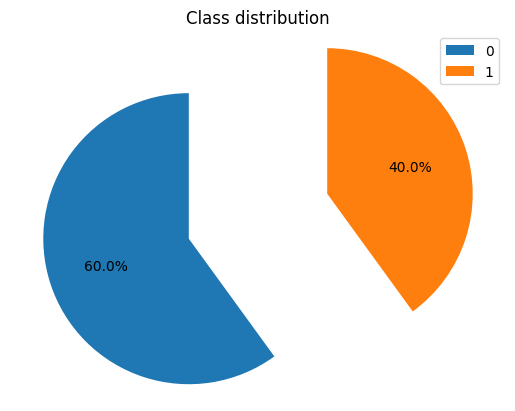

In [44]:
# taegwt class distribution
target = train_data_copy['class'].value_counts(normalize=True).round(1)
plt.pie(target, target.index, autopct='%1.1f%%', startangle=90)
plt.title('Сlass distribution')
plt.legend(target.index)
plt.axis('equal')
plt.show()


In [45]:
# deleting the uninformative column
train_data_copy.drop(['ID'],axis=1,inplace=True)

In [46]:
# general dataset information
train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   age                                   600000 non-null  float64
 1   sex                                   600000 non-null  int64  
 2   chest                                 600000 non-null  float64
 3   resting_blood_pressure                600000 non-null  float64
 4   serum_cholestoral                     600000 non-null  float64
 5   fasting_blood_sugar                   600000 non-null  int64  
 6   resting_electrocardiographic_results  600000 non-null  int64  
 7   maximum_heart_rate_achieved           600000 non-null  float64
 8   exercise_induced_angina               600000 non-null  int64  
 9   oldpeak                               600000 non-null  float64
 10  slope                                 600000 non-null  int64  
 11  

In [47]:
# rounding of values in the "Chest" column
train_data_copy['chest'] = train_data_copy['chest'].round()

In [48]:
# Number of unique values in the dataset
nunique_feature_values =  pd.Series(train_data_copy.nunique().T)
nunique_feature_values

,0
age,594106
sex,2
chest,6
resting_blood_pressure,596241
serum_cholestoral,598797
fasting_blood_sugar,2
resting_electrocardiographic_results,3
maximum_heart_rate_achieved,597583
exercise_induced_angina,2
oldpeak,384255


In [49]:
# determine which features will belong to numerical features and which will be categororial features
categorial_features = (nunique_feature_values[nunique_feature_values < 10]).index
numerical_features = (nunique_feature_values[nunique_feature_values > 10]).index

In [50]:
# convert to "object" type recognising categororial features
train_data_copy[categorial_features] = train_data_copy[categorial_features].astype('object')

In [51]:
# statistics on numerical features
round(train_data_copy.describe(),2)

,age,resting_blood_pressure,serum_cholestoral,maximum_heart_rate_achieved,oldpeak
count,600000.00,600000.00,600000.00,600000.00,600000.00
mean,54.43,131.34,249.59,149.59,1.05
std,9.09,17.84,51.70,23.07,1.14
min,26.06,82.92,98.33,61.84,-0.81
25%,48.08,119.92,216.48,135.70,0.00
50%,55.13,129.73,244.23,153.22,0.81
75%,60.66,139.92,274.35,165.17,1.67
max,79.59,209.67,527.76,208.74,6.80


In [52]:
# statistics on categorial features
round(train_data_copy.describe(include='object'),2)

,sex,chest,fasting_blood_sugar,resting_electrocardiographic_results,exercise_induced_angina,slope,number_of_major_vessels,thal,class
count,600000,600000.0,600000,600000,600000,600000,600000,600000,600000
unique,2,6.0,2,3,2,3,4,3,2
top,1,4.0,0,2,0,1,0,3,0
freq,406468,285350.0,509546,302698,399899,289149,353137,334624,333489


In [55]:
def noniformation_features(df):
    "The function checks the uninformative of the features"

    low_information_features = []

    for col in df:
        dublicates = df[col].value_counts(normalize=True).max()

        if dublicates >0.95:
            low_information_features.append(col)

    return low_information_features

In [18]:
noninformation_features_list = noniformation_features(train_data_copy)
noninformation_features_list

[]

In [19]:
# duplicate check
train_data_copy.duplicated(subset=train_data_copy.columns).sum()

np.int64(0)

In [56]:
# missing values check
train_data_copy.isna().sum()

,0
age,0
sex,0
chest,0
resting_blood_pressure,0
serum_cholestoral,0
fasting_blood_sugar,0
resting_electrocardiographic_results,0
maximum_heart_rate_achieved,0
exercise_induced_angina,0
oldpeak,0


In [57]:
def boxplot(df, numerical_features):
    "The function visualises histograms, boxplots, and violinplots for each fature in the numerical feature list"

    n = len(numerical_features)

    fig, axes = plt.subplots(n, 3, figsize=(15, 5*n))

    names_dict = {
        'age':'Age',
        'chest':'Chest',
        'resting_blood_pressure':'Resting blood pressure',
        'serum_cholestoral':'Serum cholestoral',
        'maximum_heart_rate_achieved':'Maximum heart rate achieved',
        'oldpeak':'Oldpeak'
    }

    for i, feature in enumerate(numerical_features):
        median = df[feature].median()
        mean = df[feature].mean()
        q25 = df[feature].quantile(0.25)
        q75 = df[feature].quantile(0.75)

        # histogram
        sns.histplot(df[feature],bins=25, ax=axes[i][0])
        axes[i][0].set_title(f'Histplot for {names_dict.get(feature)}')
        axes[i][0].axvline(median, color='red', linestyle='--',label='Median')
        axes[i][0].axvline(mean, color='green', linestyle='--',label='Mean')
        axes[i][0].axvline(q25, color='blue', linestyle='--',label='Q25')
        axes[i][0].axvline(q75, color='blue', linestyle='--',label='Q75')
        axes[i][0].set_xlabel(names_dict.get(feature))
        axes[i][0].legend()
        axes[i][0].grid()
        # boxplot
        sns.boxplot(y=df[feature],orient='h', ax=axes[i][1])
        axes[i][1].set_title(f'Boxplot for {names_dict.get(feature)}')
        axes[i][1].set_ylabel('Count')
        axes[i][1].grid()
        # violin
        sns.violinplot(data=train_data_copy, x='class', y=feature, hue='class', split=True, inner='box',ax=axes[i][2])
        axes[i][2].set_title(f'Violinplot for {names_dict.get(feature)}')
        axes[i][2].grid()

    plt.tight_layout()
    plt.show()

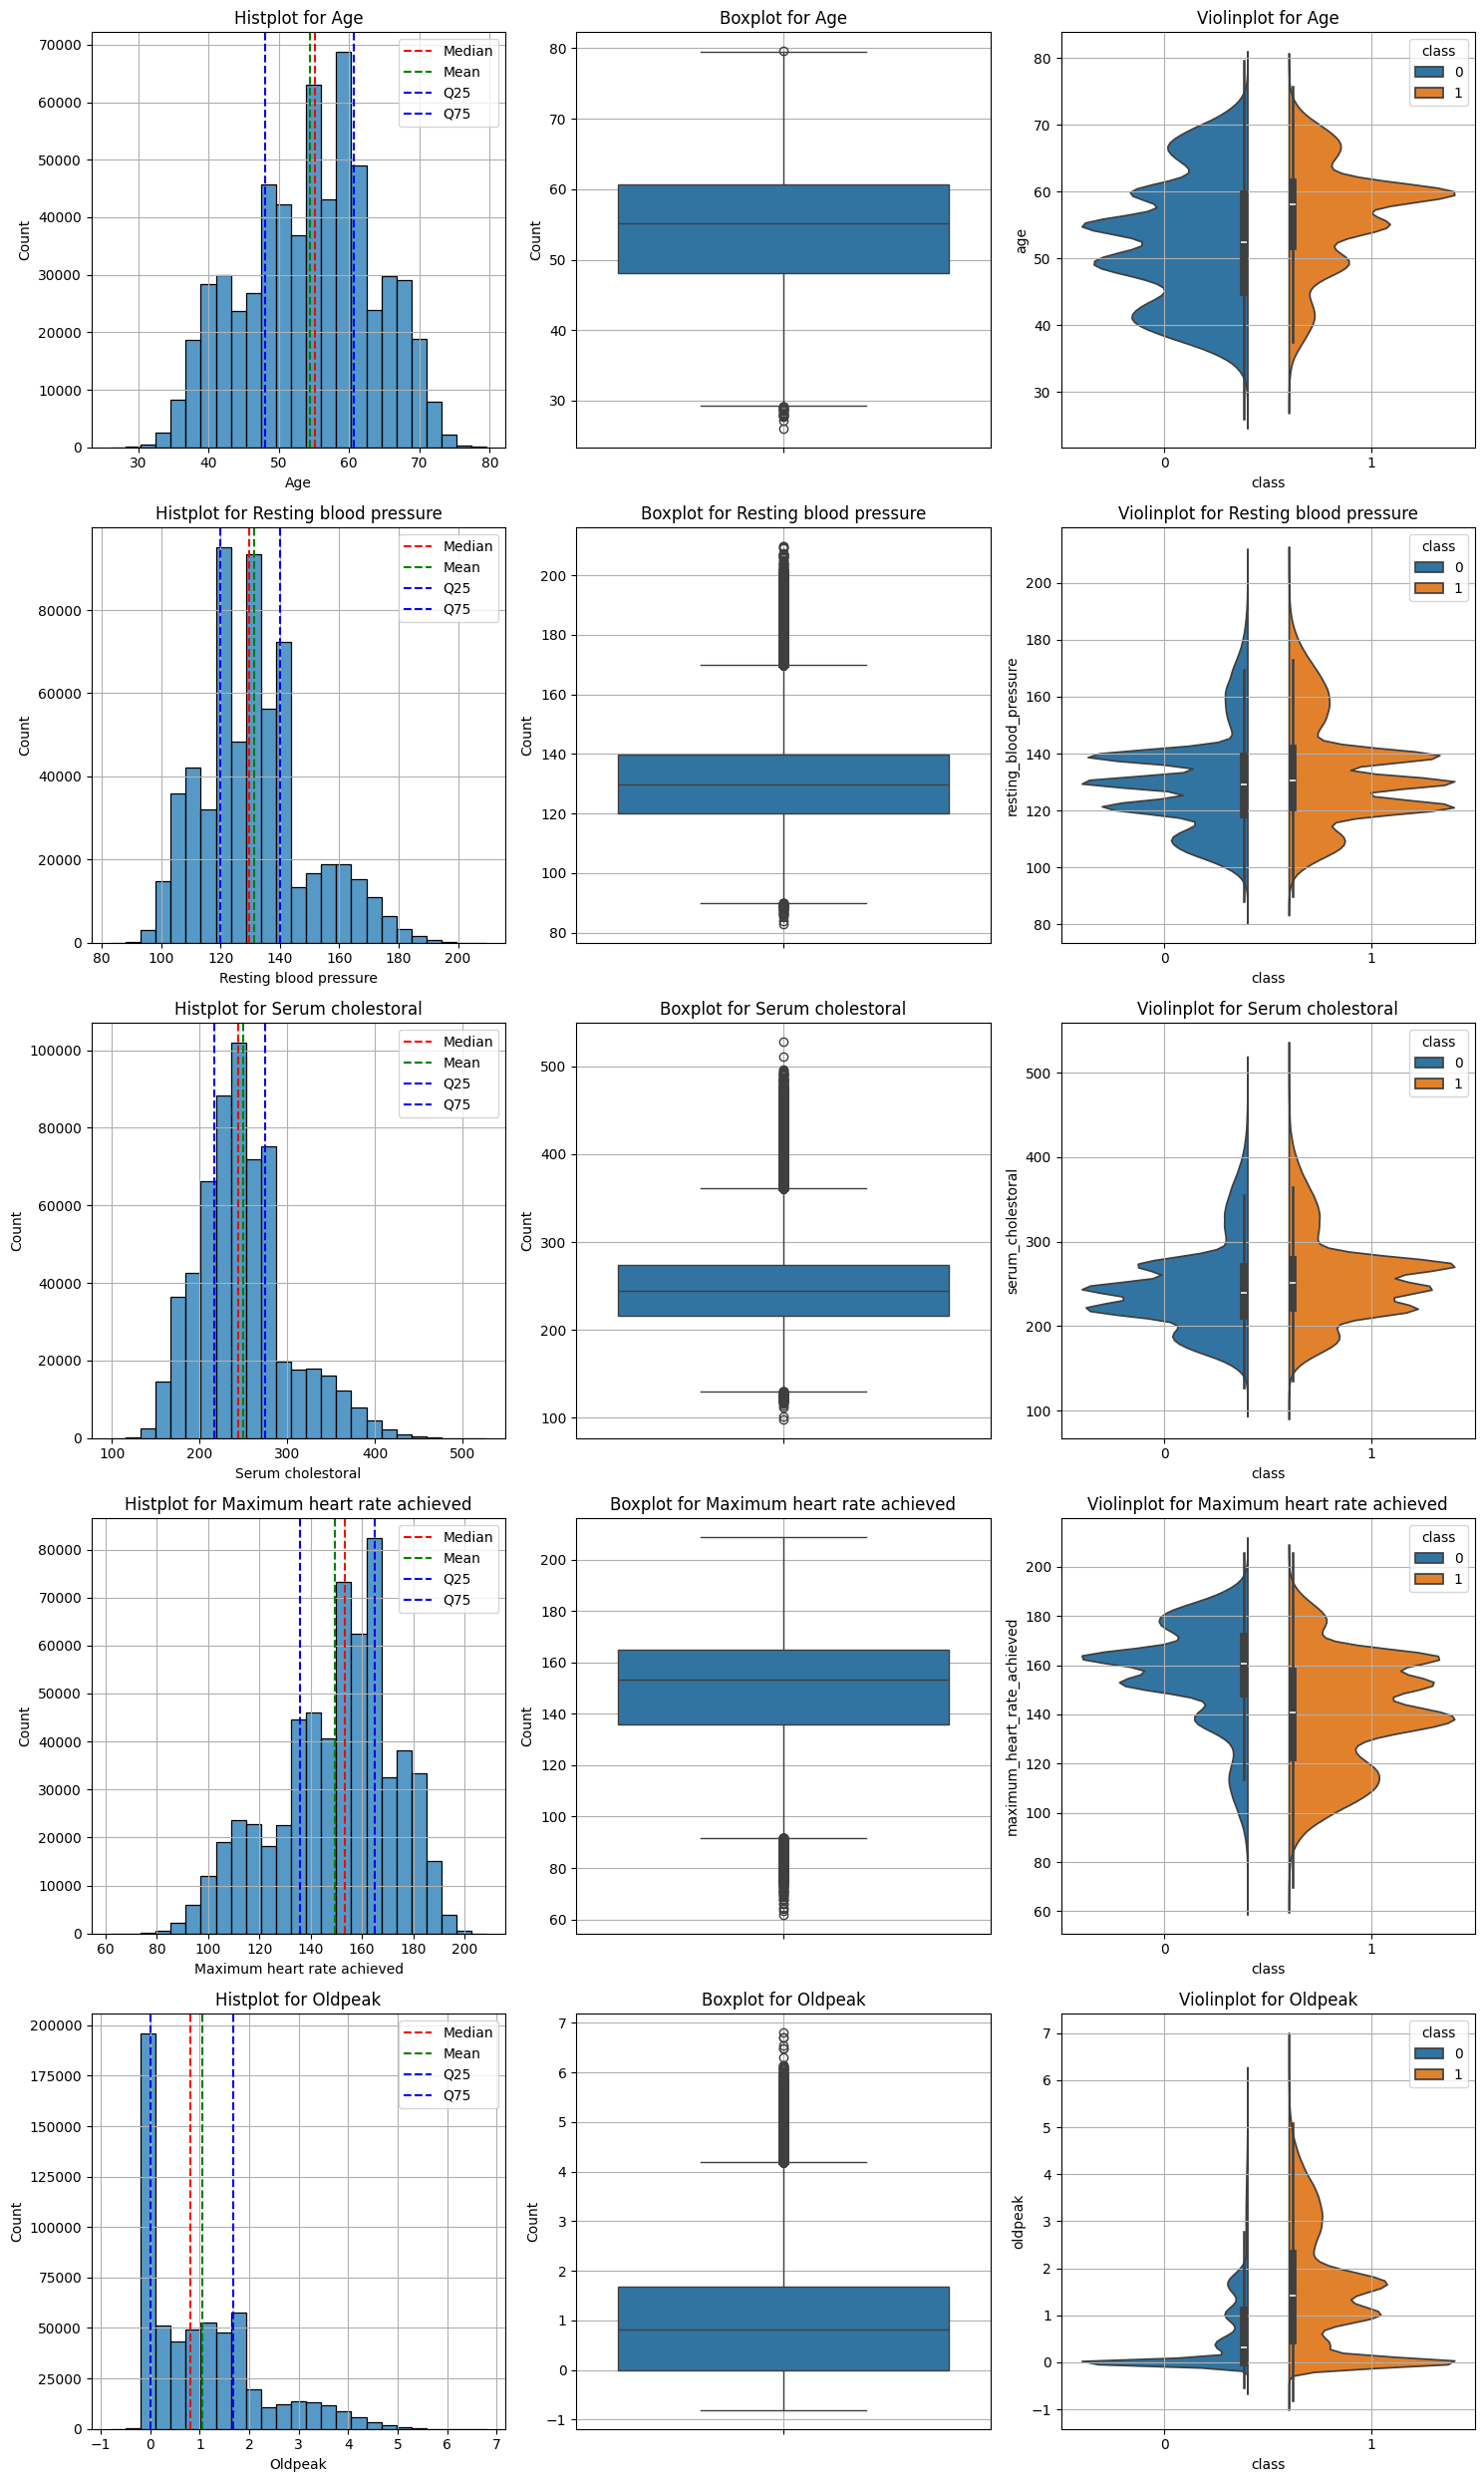

In [58]:
boxplot(train_data_copy,numerical_features)

### Conclusions

As a result of the exploratory analysis, the following conclusions can be drawn::

* The data is balanced

* There are no missing values in the data

* There are no duplicates in the data

* Analysed for the presence of uninformative signs, they were searched for more than 90% of the same values.

* For correct work, type conversion was used for prznoks in which the number of unique values is less than 10, it is also possible to note strange values for **<u>Chest</u>**, some values were specified in floating point format, it was decided to round the values in such cases to the nearest whole number

* The distribution of the data (histograms) and the presence of outliers (boxplots) were assessed..

For **<u>Age</u>** the distribution is normal and no outliers are observed in the data;

For **<u>Resting blood pressure</u>** the distribution is multidimensional with some slightly alarming high values, but in general I will not consider these values as outliers.


Sign **<u>Serum cholistoral</u>** has a log-normal distribution, large values at the end of the distribution are somewhat alarming, I will try to clean the data from outliers

The **<u>Maximum heart reate achieved</u>** trait is close to a normal distribution, overall values at the edges of the distribution appear to be within normal limits

The **<u>Oldpeak</u>** trait has a log-normal distribution, if we believe the information on the Internet, the trait values less than 0 are a variant of the norm, but the maximum value is rather an outlier, it is impossible to logarithmise the trait due to zero and negative values.


# Data preprocessing

In [59]:
# logarithmisation of the "serum_cholestoral" feature
train_data_copy['serum_cholestoral'] = np.log(train_data_copy['serum_cholestoral'])

In [60]:
# list of features to clean up outliers
list_for_clean = ['resting_blood_pressure','serum_cholestoral','oldpeak']

In [61]:
# number of rows in the dataset before cleaning
rows_before_clear = train_data_copy.shape[0]

In [62]:
# cleansing of data outliers
for feature in list_for_clean:
    x = train_data_copy[feature]
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    train_data_copy = train_data_copy[(x >= lower) & (x <= upper)]


In [63]:
# number of rows in the dataset after cleaning
rows_after_clear = train_data_copy.shape[0]

In [64]:
percentage_lost = 100 * (rows_before_clear - rows_after_clear) / rows_before_clear
print(f'Data lost:: {percentage_lost:.2f}%')

Data lost:: 6.85%


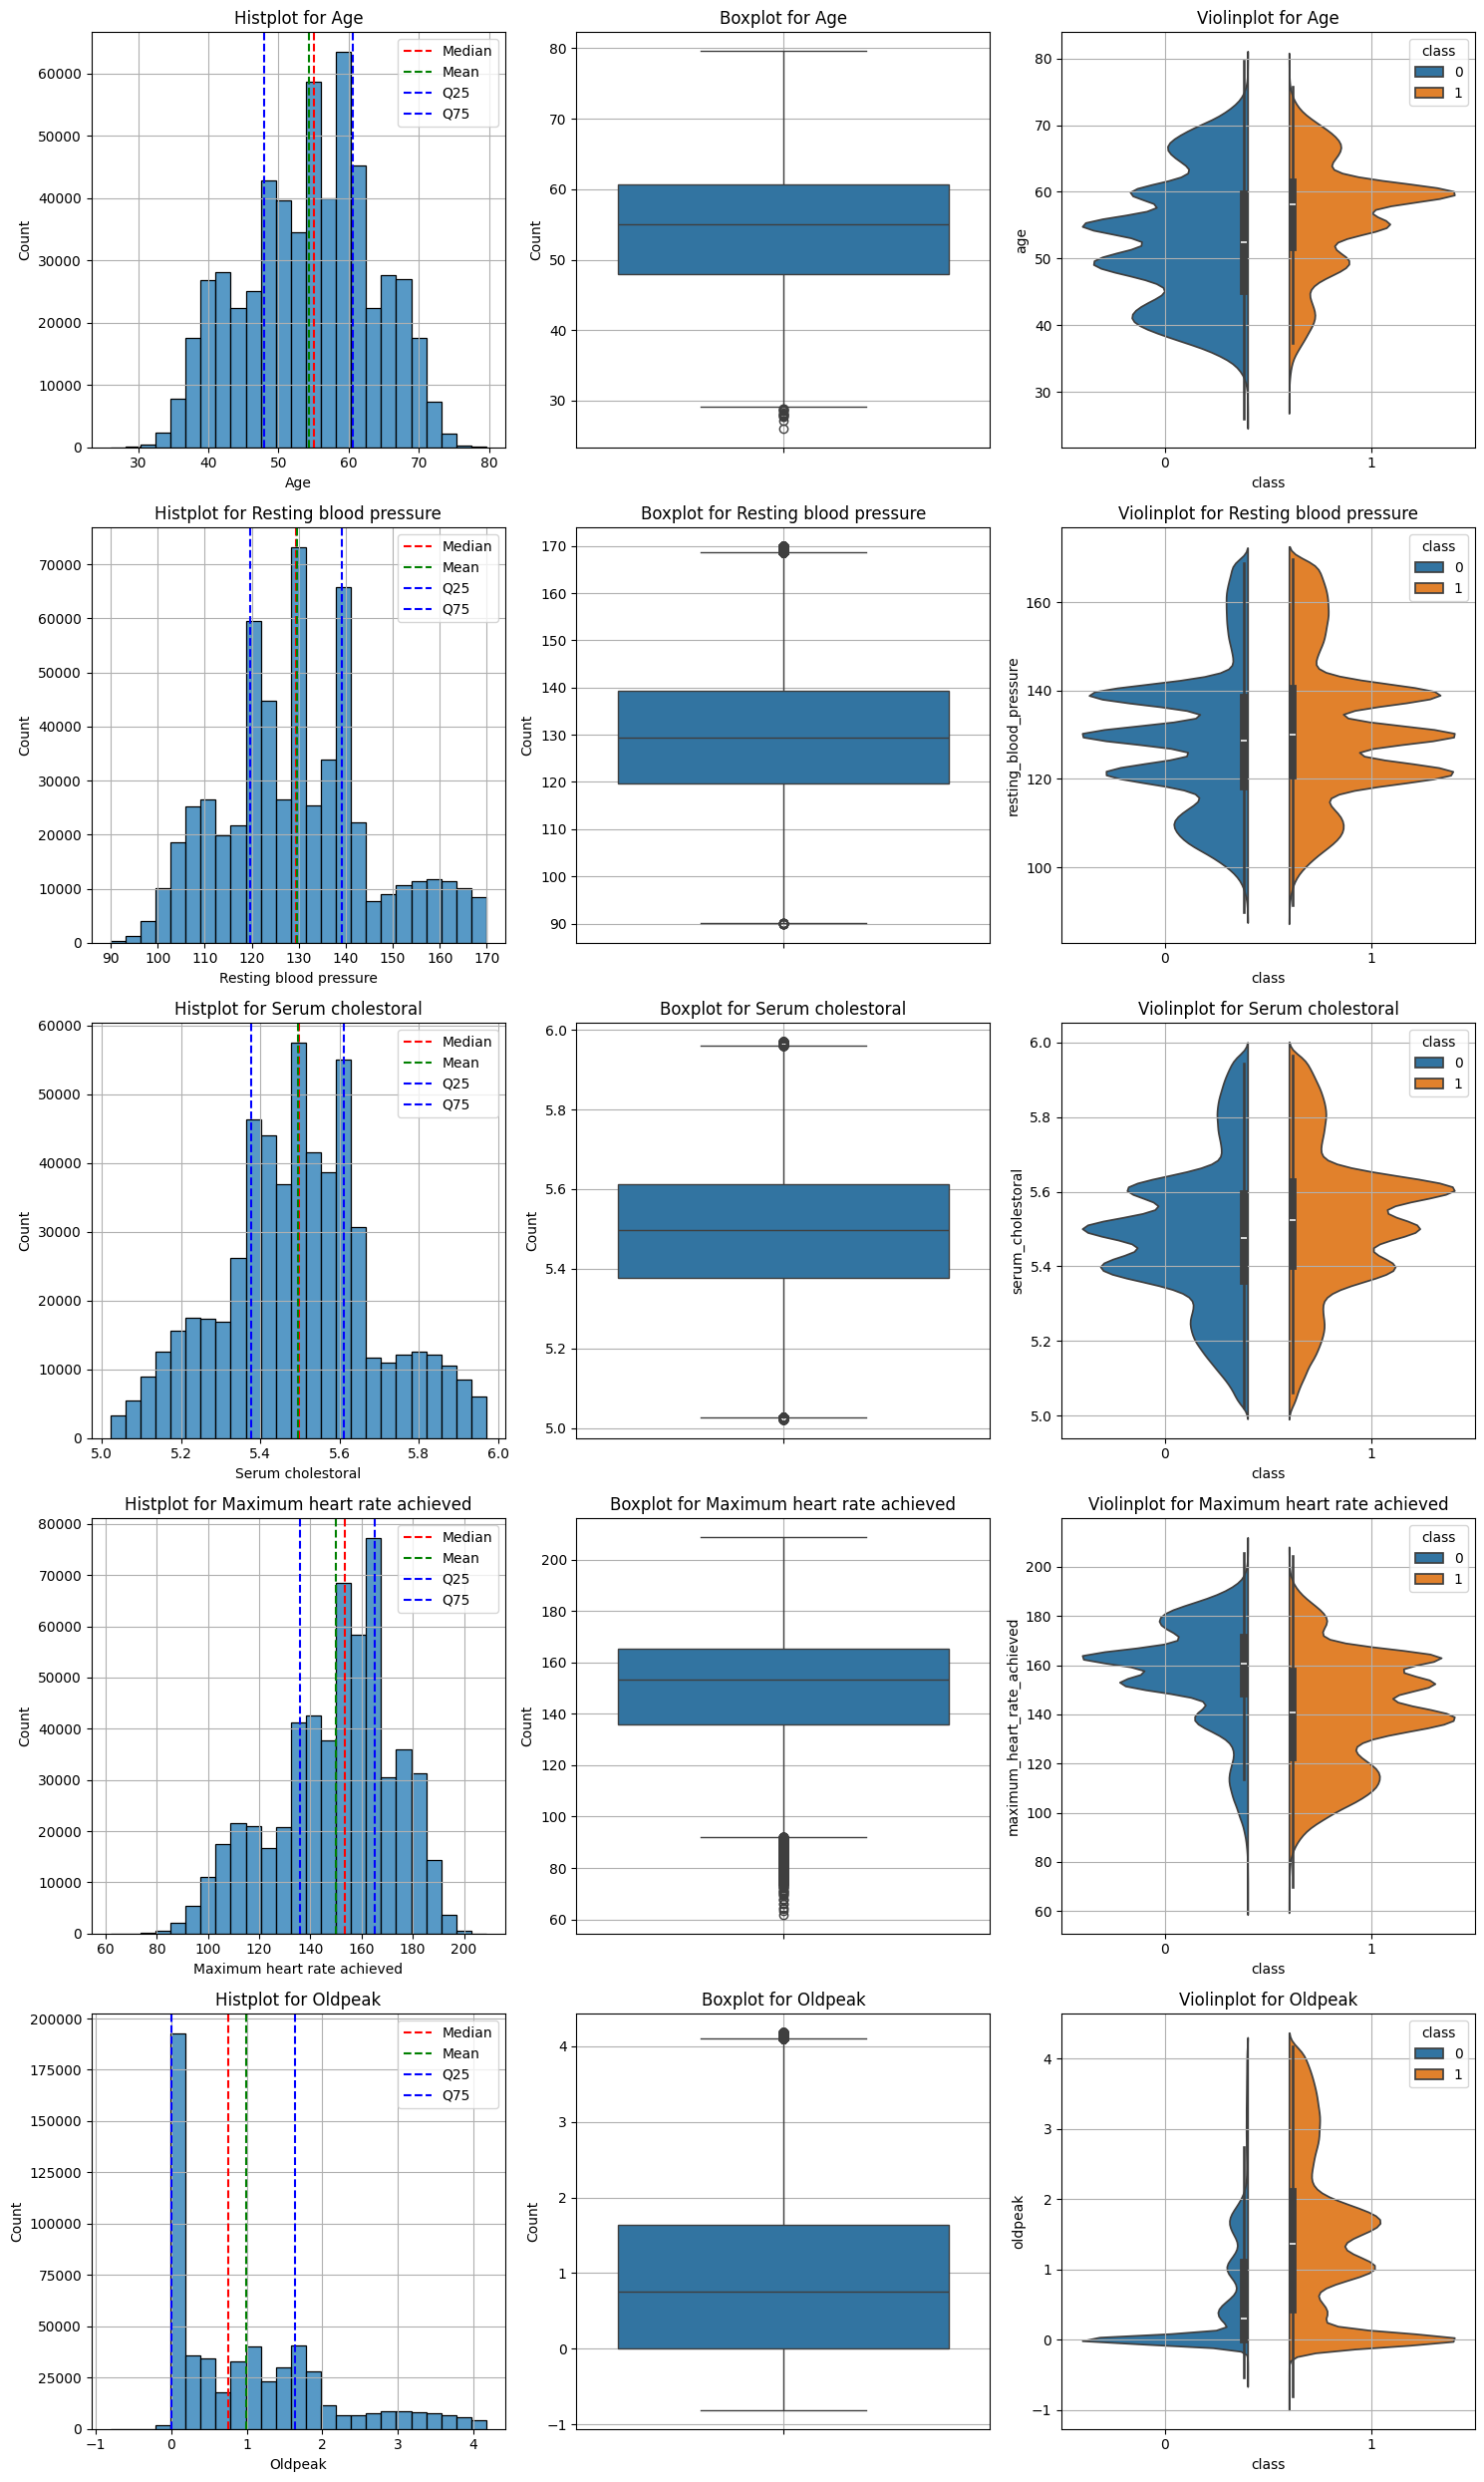

In [65]:
# visualisation after cleaning
boxplot(train_data_copy,numerical_features)

<Axes: >

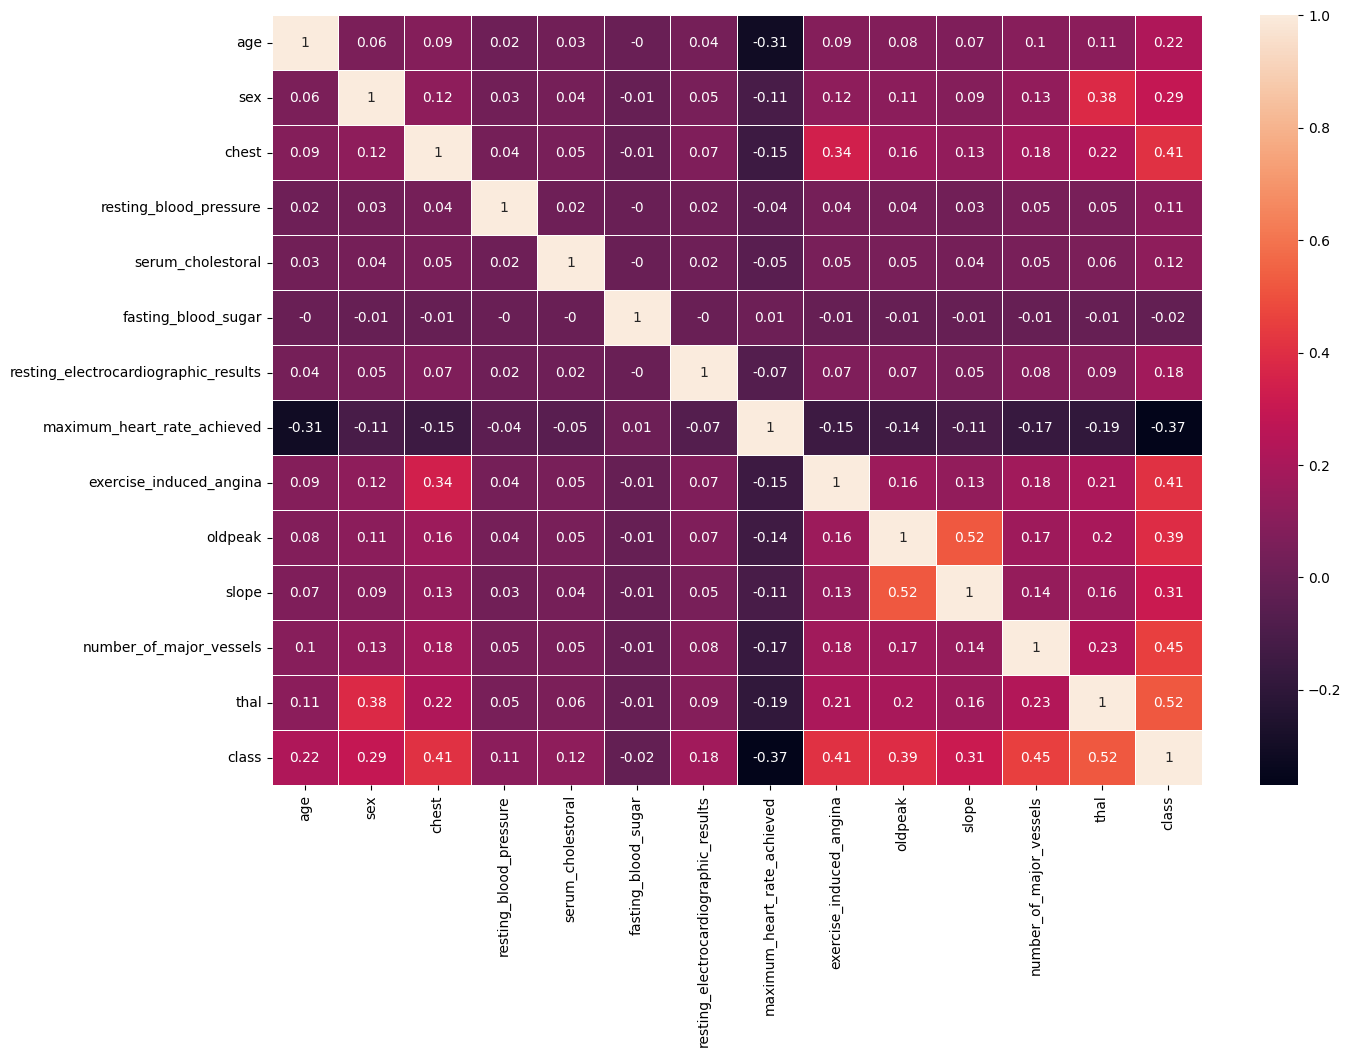

In [66]:
# heat map of correlations between features
plt.figure(figsize=(15,10))
sns.heatmap(train_data_copy.corr().round(2),annot=True,linecolor='white',linewidths=0.5)

### Preprocessing conclusion

* The dataset has been cleaned of outliers

* Checking for multicollinearity, showed that there were no such signs

# Modeling

In [67]:
# splitting the data into training features and target variable
X = train_data_copy.drop('class',axis=1)
y = train_data_copy['class'].astype(np.int8)

In [68]:
# separation of data into training and validation sample
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [69]:
# data normalisation
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

##LogisticRegression

In [70]:
# construction and prediction of logistic regression model with default settings
log_reg_model = LogisticRegression(random_state=42,class_weight='balanced')
log_reg_model.fit(X_train_scaled,y_train)
y_lr_pred_train = log_reg_model.predict(X_train_scaled)
y_lr_pred_val = log_reg_model.predict(X_val_scaled)

In [71]:
print('Results of the predictive accuracy of the model before hyperparameter fitting')
print()
print(classification_report(y_train,y_lr_pred_train))
print('-'*100)
print(classification_report(y_val,y_lr_pred_val))

Results of the predictive accuracy of the model before hyperparameter fitting

              precision    recall  f1-score   support

           0       0.90      0.88      0.89    222078
           1       0.85      0.87      0.86    169157

    accuracy                           0.88    391235
   macro avg       0.87      0.88      0.87    391235
weighted avg       0.88      0.88      0.88    391235

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     95177
           1       0.85      0.87      0.86     72496

    accuracy                           0.88    167673
   macro avg       0.88      0.88      0.88    167673
weighted avg       0.88      0.88      0.88    167673



Text(0.5, 1.0, 'Confusion matrix for Logistic Regression')

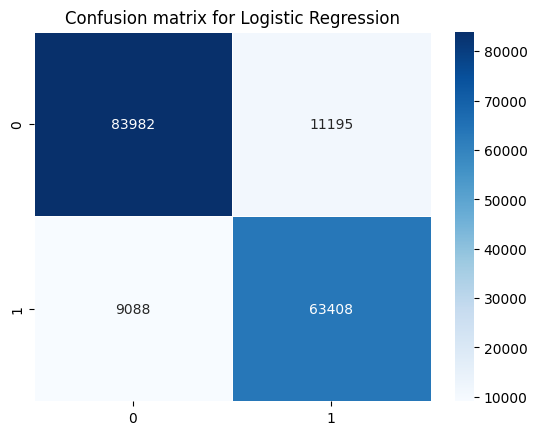

In [72]:
# confusion matrix for predictive of the model logistic regression before hyperparameter fitting
lr_cf_matrix = confusion_matrix(y_val,y_lr_pred_val)
sns.heatmap(lr_cf_matrix,annot=True,cmap='Blues',fmt='d',linewidths=0.5,linecolor='white')
plt.title('Confusion matrix for Logistic Regression')

In [73]:
# selection of optimal hyperparameters
def optuna_lr(trial):
    param = {
        'C': trial.suggest_float('C', 1e-5, 1e-2),
        'penalty': 'l2',
        'solver': 'saga',
        'max_iter': 1000,
        'random_state': 42,
        'class_weight': 'balanced',
         }


    model = LogisticRegression(**param)
    skf = StratifiedKFold(
        n_splits=3,
        random_state=42,
        shuffle=True)
    scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1

        )
    return scores.mean()

study = optuna.create_study(direction='maximize', study_name='log_reg_optuna')
study.optimize(optuna_lr, n_trials=25)

[I 2025-07-17 10:04:22,635] A new study created in memory with name: log_reg_optuna
[I 2025-07-17 10:04:34,116] Trial 0 finished with value: 0.8767518228207151 and parameters: {'C': 0.002356539356279497}. Best is trial 0 with value: 0.8767518228207151.
[I 2025-07-17 10:04:41,461] Trial 1 finished with value: 0.8767543791559119 and parameters: {'C': 0.0006071674315707449}. Best is trial 1 with value: 0.8767543791559119.
[I 2025-07-17 10:04:48,638] Trial 2 finished with value: 0.8767288187046819 and parameters: {'C': 0.005054544899092221}. Best is trial 1 with value: 0.8767543791559119.
[I 2025-07-17 10:04:55,430] Trial 3 finished with value: 0.8766546946661681 and parameters: {'C': 0.006567900066435833}. Best is trial 1 with value: 0.8767543791559119.
[I 2025-07-17 10:05:03,480] Trial 4 finished with value: 0.8767211507182697 and parameters: {'C': 0.0051588750628371385}. Best is trial 1 with value: 0.8767543791559119.
[I 2025-07-17 10:05:10,981] Trial 5 finished with value: 0.8766368025

In [74]:
# construction and prediction of logistic regression model with selected hyperparameters settings
log_reg_model = LogisticRegression(**study.best_params,
                                   penalty='l2',
                                   solver='saga',
                                   random_state=42,
                                   class_weight='balanced',
                                   max_iter=1000
                                   )
log_reg_model.fit(X_train_scaled,y_train)
y_lr_pred_val = log_reg_model.predict(X_val_scaled)

In [76]:
print('Results of the predictive accuracy of the model after hyperparameter fitting')
print()
print(classification_report(y_val,y_lr_pred_val))

Results of the predictive accuracy of the model after hyperparameter fitting

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     95177
           1       0.85      0.87      0.86     72496

    accuracy                           0.88    167673
   macro avg       0.88      0.88      0.88    167673
weighted avg       0.88      0.88      0.88    167673



Text(0.5, 1.0, 'Confusion matrix for Logistic Regression')

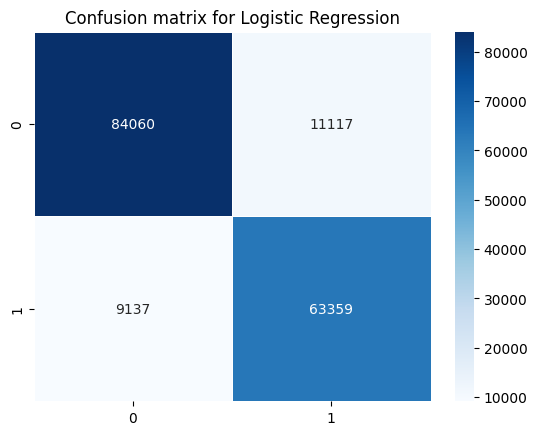

In [77]:
# confusion matrix for predictive of the model logistic regression after hyperparameter fitting
lr_cf_matrix = confusion_matrix(y_val,y_lr_pred_val)
sns.heatmap(lr_cf_matrix,annot=True,cmap='Blues',fmt='d',linewidths=0.5,linecolor='white')
plt.title('Confusion matrix for Logistic Regression')

In [78]:
# saving the trained logistic regression model
filename_lr = 'LogReg_model.joblib'
dump(log_reg_model,filename=filename_lr)

['LogReg_model.joblib']

### Conclusions on the logistic regression model

The results of model prediction are quite high.
The attempt to select hyperparameters to improve the predictive accuracy of the model was not successful, the accuracy remained at the same level as at default settings.



## Random Forest

In [79]:
# construction and prediction of random forest model with default settings
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled,y_train)
y_rf_pred_train = rf_model.predict(X_train_scaled)
y_rf_pred_val = rf_model.predict(X_val_scaled)

In [ ]:
print('Results of the predictive accuracy of the model before hyperparameter fitting')
print()
print(classification_report(y_train,y_rf_pred_train))
print('-'*100)
print(classification_report(y_val,y_rf_pred_val))

Результаты предсказательной точности модели до подбора гиперпапаметров

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    222078
           1       1.00      1.00      1.00    169157

    accuracy                           1.00    391235
   macro avg       1.00      1.00      1.00    391235
weighted avg       1.00      1.00      1.00    391235

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     95177
           1       0.89      0.87      0.88     72496

    accuracy                           0.90    167673
   macro avg       0.90      0.90      0.90    167673
weighted avg       0.90      0.90      0.90    167673



Text(0.5, 1.0, 'Confusion matrix for Random Forest')

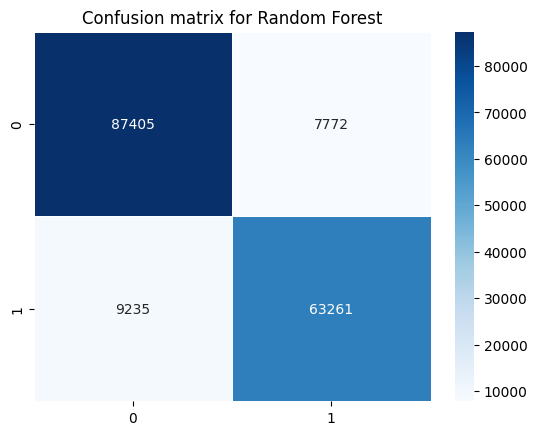

In [80]:
# confusion matrix for predictive of the model randome forest before hyperparameter fitting
rf_cf_matrix = confusion_matrix(y_val,y_rf_pred_val)
sns.heatmap(rf_cf_matrix,annot=True,cmap='Blues',fmt='d',linewidths=0.5,linecolor='white')
plt.title('Confusion matrix for Random Forest')

In [81]:
# selection of optimal hyperparameters
def optuna_rf(trial):
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'max_depth': trial.suggest_int('max_depth', 10, 15, step=5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, step=3),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 4, step=2),
        'bootstrap': True,
        'criterion': trial.suggest_categorical('criterion', ['entropy']),
    }

    model = RandomForestClassifier(
        **param,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
    skf = StratifiedKFold(
        n_splits=3
        )
    scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1
    )
    return scores.mean()


In [82]:
# selection of optimal hyperparameters
study = optuna.create_study(direction='maximize', study_name='random_forest_optuna')
study.optimize(optuna_rf, n_trials=10)

[I 2025-07-17 10:18:47,994] A new study created in memory with name: random_forest_optuna
[I 2025-07-17 10:23:04,316] Trial 0 finished with value: 0.8936010321295358 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8936010321295358.
[I 2025-07-17 10:28:49,017] Trial 1 finished with value: 0.8936623762168288 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8936623762168288.
[I 2025-07-17 10:31:19,039] Trial 2 finished with value: 0.8972765713801766 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8972765713801766.
[I 2025-07-17 10:33:16,493] Trial 3 finished with value: 0.8935371313934525 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 8, 'm

In [85]:
# construction and prediction of logistic regression model with selected hyperparameters settings
rf_model = RandomForestClassifier(**study.best_params,random_state=42,n_jobs=-1,class_weight='balanced')
rf_model.fit(X_train_scaled,y_train)
y_rf_pred_val = rf_model.predict(X_val_scaled)

In [86]:
print('Results of the predictive accuracy of the model after hyperparameter fitting')
print()
print(classification_report(y_val,y_rf_pred_val))

Results of the predictive accuracy of the model after hyperparameter fitting

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     95177
           1       0.88      0.89      0.88     72496

    accuracy                           0.90    167673
   macro avg       0.90      0.90      0.90    167673
weighted avg       0.90      0.90      0.90    167673



In [87]:
# saving the trained random forest model
fliename_rf = 'RandomForest_model.joblib'
dump(rf_model,filename=fliename_rf)

['RandomForest_model.joblib']

### Conclusions from the RandomForest model

The results of this model were better than those of the logistic regression model. An attempt was also made to improve the predictive accuracy of the model by selecting hyperparameters, and as in the previous case, there was no increase in accuracy.

## NN

In [96]:
clear_session()

In [97]:
# set callbacks
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')
checkpoint = ModelCheckpoint('model_best.keras', monitor='val_loss',save_best_only =True )
callbacks_list = [earlystop,checkpoint]

In [98]:
# create model architecture
model = M.Sequential([
    L.Dense(128,input_shape=(X_train.shape[1],)),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.Dense(128),
    L.BatchNormalization(),
    L.Activation('relu'),

    L.Dense(1, activation='sigmoid')
])

In [99]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,457 (76.00 KB)

 Trainable params: 18,945 (74.00 KB)

 Non-trainable params: 512 (2.00 KB)

In [100]:
# compile model
optimizator = optimizers.Adam(learning_rate=0.001)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizator,
    metrics=['accuracy']
)

In [102]:
# model training
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size = 32,
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = (X_val_scaled,y_val)

)

Epoch 1/20
12227/12227 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.8810 - loss: 0.2847 - val_accuracy: 0.8961 - val_loss: 0.2536
Epoch 2/20
12227/12227 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.8909 - loss: 0.2639 - val_accuracy: 0.8974 - val_loss: 0.2489
Epoch 3/20
12227/12227 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8931 - loss: 0.2584 - val_accuracy: 0.8976 - val_loss: 0.2488
Epoch 4/20
12227/12227 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8945 - loss: 0.2559 - val_accuracy: 0.8996 - val_loss: 0.2460
Epoch 5/20
12227/12227 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.8945 - loss: 0.2549 - val_accuracy: 0.8995 - val_loss: 0.2452
Epoch 6/20
12227/12227 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.8947 - loss: 0.2532 - val_accuracy: 0.9001 - val_loss: 0.2442
Epoch 7/20
12227/12227 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.8961 - loss: 0.2523 - val_accuracy: 0.9002 - val_loss: 0.2446
Epoch 8/20
12227/12227 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 

In [103]:
def plot_history(history):

    "Visualisation of neural network learning curves"

    plt.figure(figsize = (10,5))
    acc =  history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label = 'Training accuracy')
    plt.plot(epochs, val_acc,'g', label ='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize = (10,5))
    plt.plot(epochs,loss,'b',label = 'Training loss')
    plt.plot(epochs,val_loss,'g',label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.grid()
    plt.show()

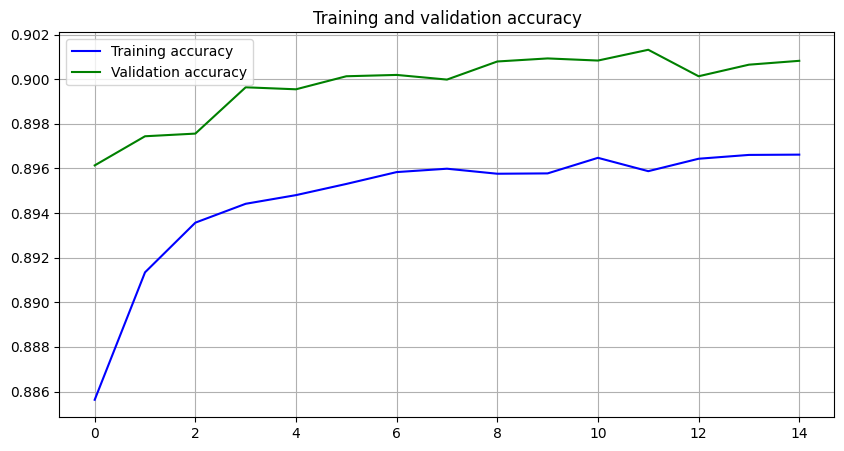

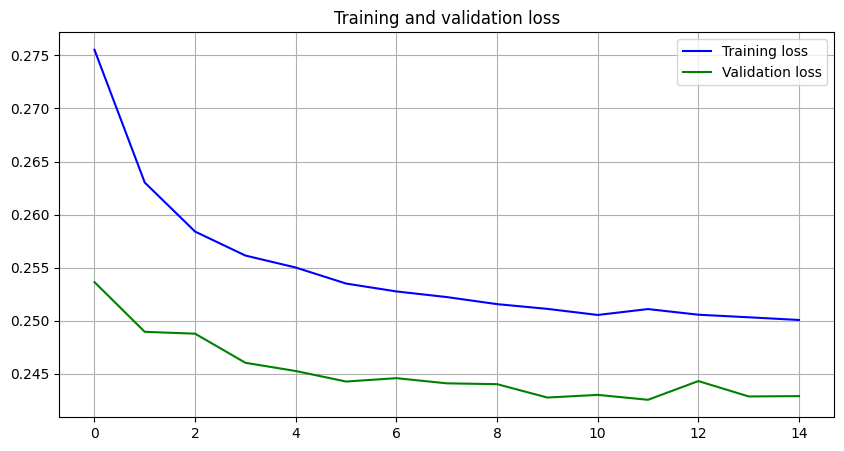

In [104]:
plot_history(history)

In [105]:
# neural network prediction and translation of probabilities into classes
y_nn_pred_val = model.predict(X_val_scaled,verbose=1)
y_nn_pred_val = (y_nn_pred_val > 0.5).astype("int32")


5240/5240 ━━━━━━━━━━━━━━━━━━━━ 4s 835us/step


              precision    recall  f1-score   support

           0       0.91      0.92      0.91     95177
           1       0.89      0.88      0.88     72496

    accuracy                           0.90    167673
   macro avg       0.90      0.90      0.90    167673
weighted avg       0.90      0.90      0.90    167673



Text(0.5, 1.0, 'Confusion matrix for Neural Network')

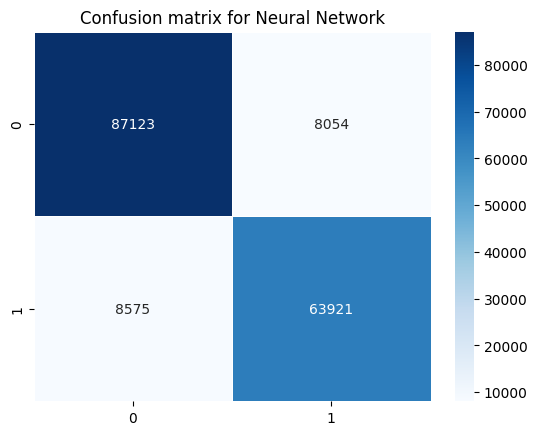

In [106]:
print(classification_report(y_val,y_nn_pred_val))
# confusion matrix for predictive of the neural network
nn_cf_matrix = confusion_matrix(y_val,y_nn_pred_val)
sns.heatmap(nn_cf_matrix,annot=True,cmap='Blues',fmt='d',linewidths=0.5,linecolor='white')
plt.title('Confusion matrix for Neural Network')

In [ ]:
# saving the trained nureal network
model.save("NN_model.keras")

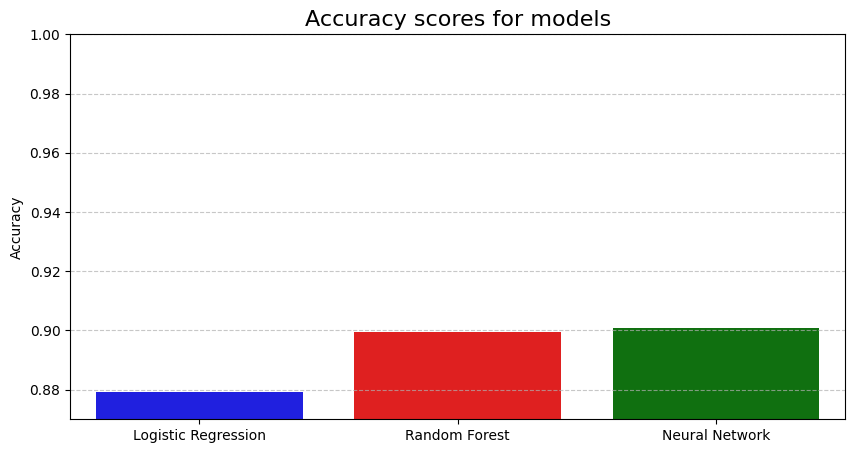

In [111]:
#  accuracy plot for used models
lr_acc = accuracy_score(y_val,y_lr_pred_val)
rf_acc = accuracy_score(y_val,y_rf_pred_val)
nn_acc = accuracy_score(y_val,y_nn_pred_val)
models = ['Logistic Regression', 'Random Forest', 'Neural Network']
accuracies = [lr_acc, rf_acc, nn_acc]

plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=accuracies, palette=['blue', 'red', 'green'])
plt.title('Accuracy scores for models', fontsize=16)
plt.ylim(0.87,1)
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)

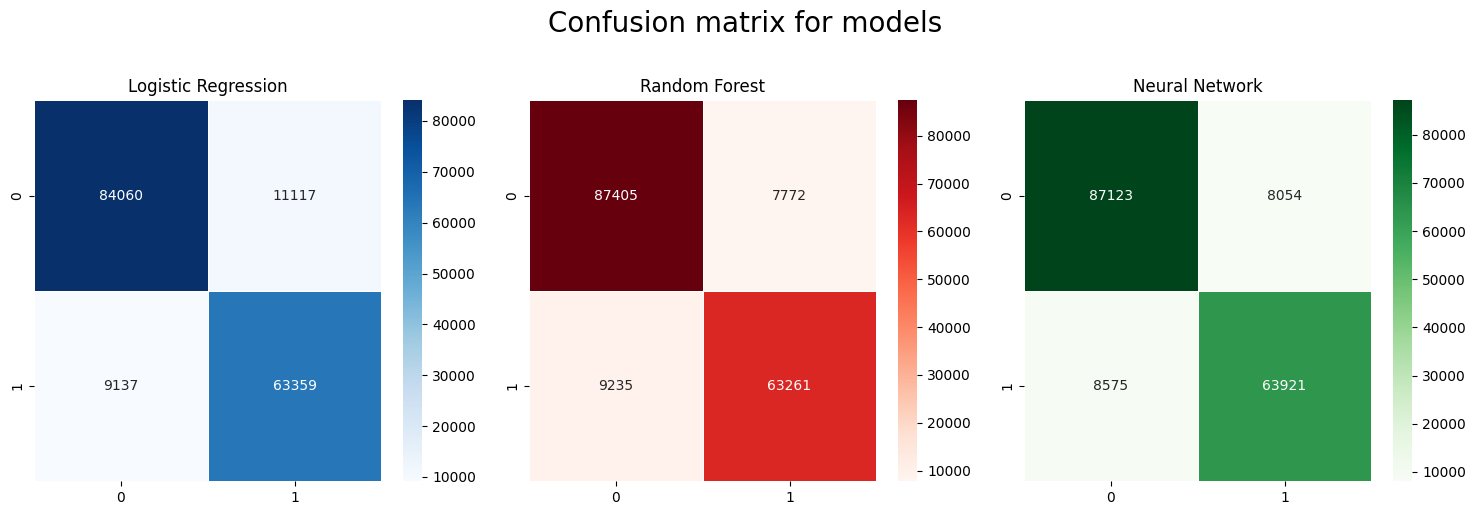

In [109]:
# confusion maxrtix for used models
fig, axes = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Confusion matrix for models', fontsize=20, y=1.02)
sns.heatmap(lr_cf_matrix,annot=True,cmap='Blues',fmt='d',linewidths=0.5,linecolor='white',ax=axes[0])
axes[0].set_title('Logistic Regression')
sns.heatmap(rf_cf_matrix,annot=True,cmap='Reds',fmt='d',linewidths=0.5,linecolor='white',ax=axes[1])
axes[1].set_title('Random Forest')
sns.heatmap(nn_cf_matrix,annot=True,cmap='Greens',fmt='d',linewidths=0.5,linecolor='white',ax=axes[2])
axes[2].set_title('Neural Network')
plt.tight_layout()

# General conclusion

Three models were trained in this study: logistic regression, a random forest classifier, and a fully connected neural network. Attempts to improve performance through hyperparameter tuning did not lead to a significant increase in accuracy. The highest validation accuracy (0.9) was achieved by both the random forest and the neural network models. However, the random forest tended to produce more false positives, while the neural network more often produced false negatives.
